# Enron Email Dataset

In [74]:
# !python3 -m pip install -U pandas numpy matplotlib seaborn pyldavis scikit-learn imblearn spacy 
# !python3 -m spacy download en_core_web_sm

import itertools
import re
import warnings
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_context('notebook')
plt.rcParams['font.size'] = 12
pyLDAvis.enable_notebook()
random_state = 5

# Dataset Information
Let's explore the dataset.

In [3]:
# Read the CSV file
df_mail = pd.read_csv('enron_test.csv', sep=',', header=0)

# Print dataframe info
df_mail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1000 non-null   object
 1   From      1000 non-null   object
 2   To        995 non-null    object
 3   Subject   698 non-null    object
 4   content   1000 non-null   object
 5   new_date  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


Let's view a few rows of data:

In [41]:
df_mail.tail(5)

,Date,From,To,Subject,content,new_date
995,"Mon, 19 Mar 2001 01:36:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),NaN,"Jacques,\n\nStill trying to close the loop on the $15,000 of extensions. Assuming that \nit is ...",2001-03-19 09:36:00
996,"Mon, 19 Mar 2001 00:45:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'llewter@austin.rr.com'}),Re: Buyout,"Larrry,\n\nI realize you are disappointed about the project. It is not my desire for \nyou to b...",2001-03-19 08:45:00
997,"Wed, 6 Dec 2000 08:04:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'pallen70@hotmail.com'}),NaN,---------------------- Forwarded by Phillip K Allen/HOU/ECT on 12/06/2000 \n04:04 PM -----------...,2000-12-06 16:04:00
998,"Fri, 16 Mar 2001 04:28:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),NaN,"Jacques,\n\nI think we reached an agreement with George and Larry to pick up the items of \nvalu...",2001-03-16 12:28:00
999,"Thu, 15 Mar 2001 07:42:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'matt.smith@enron.com'}),Matt Smith,---------------------- Forwarded by Phillip K Allen/HOU/ECT on 03/15/2001 \n03:41 PM -----------...,2001-03-15 15:42:00


'Date' and 'new_date' columns are showing the same data for different time zones (PST and UTC). Let's sort emails by date.

In [5]:
df_sorted = df_mail.sort_values(by=['new_date'])

In [6]:
df_sorted

,Date,From,To,Subject,content,new_date
716,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),"frozenset({'john.lavorato@enron.com', 'scott.n...",systems wish list,attached is the systems wish list for the gas ...,1980-01-01 00:00:00
715,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'jsmith@austintx.com'}),Re: MISSION SOUTH,"Jeff,\n\n I want to bid $2.8 for sagewood with...",1980-01-01 00:00:00
698,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),"frozenset({'stephen.harrington@enron.com', 'ma...",NaN,EOL report for TV in conference on 33\n\n\nCas...,1980-01-01 00:00:00
664,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'muller@thedoghousemail.com'}),Re: (No Subject),How is your racing going? What category are y...,1980-01-01 00:00:00
842,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",frozenset({'phillip.allen@enron.com'}),frozenset({'maryrichards7@hotmail.com'}),Re:,"Mary,\n\n It is OK to buy a carpet shampooer.\...",1980-01-01 00:00:00
...,...,...,...,...,...,...
881,"Mon, 14 May 2001 09:39:00 -0700 (PDT)",frozenset({'ei_editor@ftenergy.com'}),frozenset({'einsighthtml@spector.ftenergy.com'}),Texas puts reliability rules through paces,Dear Energy Insight Subscribers.?If you canno...,2001-05-14 16:39:00
883,"Mon, 14 May 2001 10:24:00 -0700 (PDT)",frozenset({'webmaster@earnings.com'}),frozenset({'pallen@enron.com'}),"Freidman, Billings Initiates Coverage of PMCS","If you cannot read this email, please click he...",2001-05-14 17:24:00
882,"Mon, 14 May 2001 10:32:00 -0700 (PDT)",frozenset({'perfmgmt@enron.com'}),frozenset({'pallen@enron.com'}),Mid-Year 2001 Performance Feedback,"ALLEN, PHILLIP K,\n?\nYou have been selected t...",2001-05-14 17:32:00
116,"Mon, 14 May 2001 13:39:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'outlook.team@enron.com'}),Re: 2- SURVEY/INFORMATION EMAIL 5-14- 01,\n\n\n\n\nOutlook Migration Team@ENRON\n05/11/...,2001-05-14 20:39:00


It seems that some emails are manually dated as 1980-01-01 00:00:00. Let's remove redundant column 'Date'.

In [7]:
df_sorted = df_sorted.drop('Date', axis=1)

In [8]:
df_sorted['new_date'].value_counts()

1980-01-01 00:00:00    5
2000-06-06 12:27:00    4
2000-08-20 17:39:00    4
2001-04-23 10:40:00    4
2000-09-25 14:01:00    4
                      ..
2001-03-15 12:39:00    1
2001-04-19 00:51:00    1
2001-04-18 08:22:00    1
2001-03-05 15:21:00    1
2001-05-07 23:23:00    1
Name: new_date, Length: 650, dtype: int64

In [9]:
df_sorted['new_date'] = pd.to_datetime(df_sorted['new_date'])

From the value counts information, 5 emails are manually dated and the rest of emails start after year 2000.

Let's for duplicate rows of data:

In [42]:
df_sorted_dups = df_sorted[df_sorted.duplicated()]
print("Duplicate Rows except first occurrence:")
df_sorted_dups

Duplicate Rows except first occurrence:


,From,To,Subject,content,new_date
276,frozenset({'phillip.allen@enron.com'}),frozenset({'naomi.johnston@enron.com'}),NaN,"Naomi,\n\nThe two analysts that I have had contact with are Matt Lenhart and Vishal \nApte.\nMa...",1999-12-10 15:00:00
275,frozenset({'phillip.allen@enron.com'}),frozenset({'pallen70@hotmail.com'}),Stick it in your Shockmachine!,---------------------- Forwarded by Phillip K Allen/HOU/ECT on 12/11/99 02:39 \nPM -------------...,1999-12-11 14:39:00
877,frozenset({'phillip.allen@enron.com'}),frozenset({'patti99@hotmail.com'}),Re: Are you trying to be funny?,What did mary write? Stage misses you? I sent 2 emails.\n\nMaybe mary is stalking gary,2000-01-05 13:35:00
874,frozenset({'phillip.allen@enron.com'}),frozenset({'maryrichards7@hotmail.com'}),Re: receipts,received the file. It worked. Good job.,2000-01-06 15:19:00
272,frozenset({'phillip.allen@enron.com'}),frozenset({'maryrichards7@hotmail.com'}),Re:,"Mary \n\nReceived an email from you on 1/7, but there was no message. Please try \nagain.\n\nPh...",2000-01-08 07:29:00
...,...,...,...,...,...
282,frozenset({'phillip.allen@enron.com'}),"frozenset({'stanley.horton@enron.com', 'dmccarty@enron.com'})",California Summary,---------------------- Forwarded by Phillip K Allen/HOU/ECT on 05/07/2001 \n11:22 AM -----------...,2001-05-07 13:23:00
892,frozenset({'phillip.allen@enron.com'}),frozenset({'jsmith@austintx.com'}),NaN,"Jeff,\n\nJacques Craig will draw up a release. What is the status on the quote from \nWade? \n...",2001-05-10 07:50:00
279,frozenset({'phillip.allen@enron.com'}),frozenset({'jsmith@austintx.com'}),NaN,"Let me know when you get the quotes from Pauline. I am expecting to pay \nsomething in the $3,0...",2001-05-11 06:26:00
278,frozenset({'phillip.allen@enron.com'}),frozenset({'outlook.team@enron.com'}),Re: 2- SURVEY/INFORMATION EMAIL 5-14- 01,"Outlook Migration Team@ENRON\n05/11/2001 01:49 PM\nTo: Cheryl Wilchynski/HR/Corp/Enron@ENRON, Ci...",2001-05-14 08:39:00


Wow, we actually have 336 duplicates. Let's remove those rows:

In [11]:
df_clean = df_sorted.drop_duplicates(keep="first", inplace=False)
df_clean.is_copy = None

In [12]:
df_clean

,From,To,Subject,content,new_date
716,frozenset({'phillip.allen@enron.com'}),"frozenset({'john.lavorato@enron.com', 'scott.n...",systems wish list,attached is the systems wish list for the gas ...,1980-01-01 00:00:00
715,frozenset({'phillip.allen@enron.com'}),frozenset({'jsmith@austintx.com'}),Re: MISSION SOUTH,"Jeff,\n\n I want to bid $2.8 for sagewood with...",1980-01-01 00:00:00
698,frozenset({'phillip.allen@enron.com'}),"frozenset({'stephen.harrington@enron.com', 'ma...",NaN,EOL report for TV in conference on 33\n\n\nCas...,1980-01-01 00:00:00
664,frozenset({'phillip.allen@enron.com'}),frozenset({'muller@thedoghousemail.com'}),Re: (No Subject),How is your racing going? What category are y...,1980-01-01 00:00:00
842,frozenset({'phillip.allen@enron.com'}),frozenset({'maryrichards7@hotmail.com'}),Re:,"Mary,\n\n It is OK to buy a carpet shampooer.\...",1980-01-01 00:00:00
...,...,...,...,...,...
881,frozenset({'ei_editor@ftenergy.com'}),frozenset({'einsighthtml@spector.ftenergy.com'}),Texas puts reliability rules through paces,Dear Energy Insight Subscribers.?If you canno...,2001-05-14 16:39:00
883,frozenset({'webmaster@earnings.com'}),frozenset({'pallen@enron.com'}),"Freidman, Billings Initiates Coverage of PMCS","If you cannot read this email, please click he...",2001-05-14 17:24:00
882,frozenset({'perfmgmt@enron.com'}),frozenset({'pallen@enron.com'}),Mid-Year 2001 Performance Feedback,"ALLEN, PHILLIP K,\n?\nYou have been selected t...",2001-05-14 17:32:00
116,frozenset({'phillip.allen@enron.com'}),frozenset({'outlook.team@enron.com'}),Re: 2- SURVEY/INFORMATION EMAIL 5-14- 01,\n\n\n\n\nOutlook Migration Team@ENRON\n05/11/...,2001-05-14 20:39:00


Let's check for duplicate email bodies:

In [13]:
df_clean_dups = df_clean[df_clean['content'].duplicated()]
print("Duplicate Rows except first occurrence:")
df_clean_dups

Duplicate Rows except first occurrence:


,From,To,Subject,content,new_date
385,frozenset({'phillip.allen@enron.com'}),frozenset({'jsmith@austintx.com'}),NaN,"Jeff,\n\nI am in the office today. Any isssue...",2001-04-18 18:22:00
330,frozenset({'phillip.allen@enron.com'}),frozenset({'julie.pechersky@enron.com'}),Re: Do you still access data from Inteligence ...,I still use this service,2001-04-19 20:00:00
310,frozenset({'phillip.allen@enron.com'}),frozenset({'karen.buckley@enron.com'}),Re: FW: Trading Track Program,I think Chad deserves an interview.,2001-04-23 20:31:00
216,frozenset({'phillip.allen@enron.com'}),frozenset({'eric.benson@enron.com'}),Re: Instructions for FERC Meetings,it works. thank you,2001-04-25 00:26:00
139,frozenset({'phillip.allen@enron.com'}),frozenset({'jsmith@austintx.com'}),Re: Leander etc.,I would look at properties in San Antonio or D...,2001-04-27 00:01:00
117,frozenset({'phillip.allen@enron.com'}),frozenset({'lisa.jones@enron.com'}),Re: Analyst Resume - Rafael Avila,Send to Karen Buckley. Trading track intervie...,2001-04-27 20:37:00
440,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,The west desk would like 2 analysts.,2001-05-10 00:13:00


We have 7 emails with duplicate contents but the recipients are different. So I'll keep them.

# Internal and External Emails

Let's clean up 'From' and 'To' rows to include only email adddresses.

In [14]:
df_clean['To'].isnull().sum()

4

Let's exclude this 4 rows when processing 'To' column.

In [15]:
df_clean['From'] = df_clean['From'].apply(lambda x:
                                            ','.join([val.strip().strip("'")\
                                          for val in x.strip("frozenset({})").split(',')]))

df_clean.loc[df_clean['To'].notnull(), 'To'] =\
    df_clean.loc[df_clean['To'].notnull(), 'To'].\
    apply(lambda x: ','.join([val.strip().strip("'") for val in x.strip("frozenset({})").split(',')]))

In [16]:
df_clean['To']

716    john.lavorato@enron.com,scott.neal@enron.com,t...
715                                  jsmith@austintx.com
698          stephen.harrington@enron.com,mary@enron.com
664                           muller@thedoghousemail.com
842                            maryrichards7@hotmail.com
                             ...                        
881                    einsighthtml@spector.ftenergy.com
883                                     pallen@enron.com
882                                     pallen@enron.com
116                               outlook.team@enron.com
0                                   tim.belden@enron.com
Name: To, Length: 664, dtype: object

Considering that all external email have at least one recipient or sender outside enron.com domain, let's find the distribution of each category.

In [17]:
df_clean['type'] = 'internal'
for ind, row in df_clean.iterrows():
        from_emails = row['From']
        if row['To'] == np.nan or type(row['To'])==float: # Do not consider nan values
            row['To'] = ''
        to_emails = row['To']
        for val in from_emails.split(','):
            if val.split('@')[1] != 'enron.com':
                df_clean.loc[ind, 'type'] = 'external'
                break
        if to_emails and row['type']=='internal':
            for val in to_emails.split(','):
                if str(val).split('@')[1] != 'enron.com':
                    df_clean.loc[ind, 'type'] = 'external'
                    break

In [18]:
df_clean['type'].value_counts()

internal    373
external    291
Name: type, dtype: int64

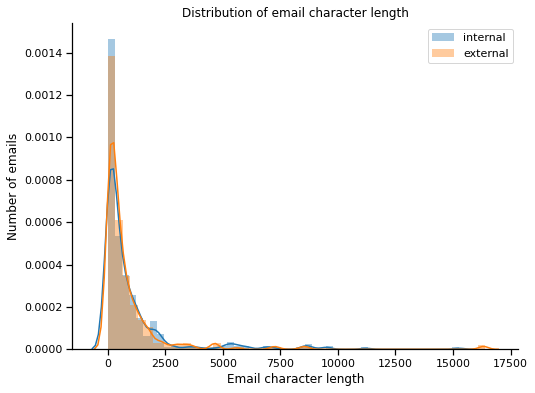

In [69]:
fig = plt.figure(figsize=(8, 6))
internal = [len(d) for d in df_clean.loc[df_clean['type'] == 'internal', 'content']]
external = [len(d) for d in df_clean.loc[df_clean['type'] == 'external', 'content']]
sns.distplot(internal, label='internal')
sns.distplot(external, label='external')
plt.title('Distribution of email character lengths')
plt.ylabel('Number of emails')
plt.xlabel('Email character lengths')
plt.legend()
sns.despine()

Visually, it looks like emails in both internal and external groups have similar distribution of character lengths. Let's check Kolmogorov-Smirnov statistic on data with null hyothesis that distribution of both internal and external email lengths are the same with a significance level of 0.05.

In [20]:
sc.stats.ks_2samp(np.array(internal), np.array(external))

Ks_2sampResult(statistic=0.06483144928737919, pvalue=0.47224745736217943)

The p-value is greater than the significance level of 0.05. Therefore, we cannot reject the null hypothesis.

# Emails sent and recieved over a span of time

Let's get a value count on "From" and "To" columns:

In [21]:
df_clean['From'].value_counts()

phillip.allen@enron.com                    610
critical.notice@enron.com                    5
ina.rangel@enron.com                         4
messenger@ecm.bloomberg.com                  2
aod@newsdata.com                             2
sarah.novosel@enron.com                      2
announce@inbox.nytimes.com                   2
jsmith@austintx.com                          2
webmaster@earnings.com                       2
ei_editor@ftenergy.com                       2
grensheltr@aol.com                           1
richard.shapiro@enron.com                    1
bobregon@bga.com                             1
rebecca.cantrell@enron.com                   1
tiffany.miller@enron.com                     1
christi.nicolay@enron.com                    1
philip.polsky@enron.com                      1
tracy.arthur@enron.com                       1
yahoo-delivers@yahoo-inc.com                 1
frank.hayden@enron.com                       1
paul.kaufman@enron.com                       1
owner-strawba

Looks like 610 emails out of 644 are from "phillip.allen@enron.com".

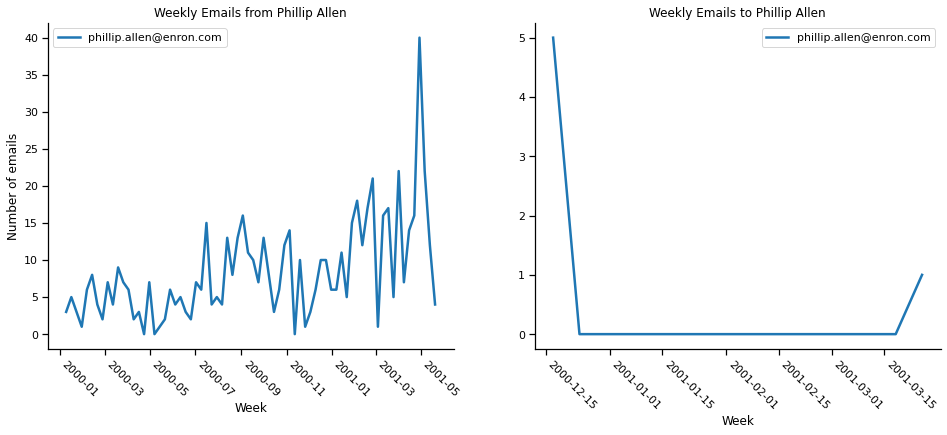

In [22]:
grouped_by_sender = df_clean.set_index('new_date').groupby(['From'])
grouped_by_recipient = df_clean.set_index('new_date').groupby(['To'])

# Plot weekly emails from Phillip Allen

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
df = grouped_by_sender.get_group('phillip.allen@enron.com')
sns.lineplot(
    data=df.loc['2000-01-01':,'To'].resample("1w").count(), 
    label = 'phillip.allen@enron.com',
    linewidth=2.5, ax=ax1)
sns.despine()
ax1.title.set_text('Weekly Emails from Phillip Allen')
ax1.set_ylabel('Number of emails')
ax1.set_xlabel('Date')
plt.setp(ax1.get_xticklabels(), rotation=-45, ha='left')

df = grouped_by_recipient.get_group('phillip.allen@enron.com')
sns.lineplot(
    data=df.loc['2000-01-01':,'From'].resample("1w").count(), 
    label = 'phillip.allen@enron.com',
    linewidth=2.5, ax=ax2)
sns.despine()
ax2.title.set_text('Weekly Emails to Phillip Allen')
ax2.set_xlabel('Date')
plt.setp(ax2.get_xticklabels(), rotation=-45, ha='left')
plt.show()

Others haven't been as active as Philip in sending emails:

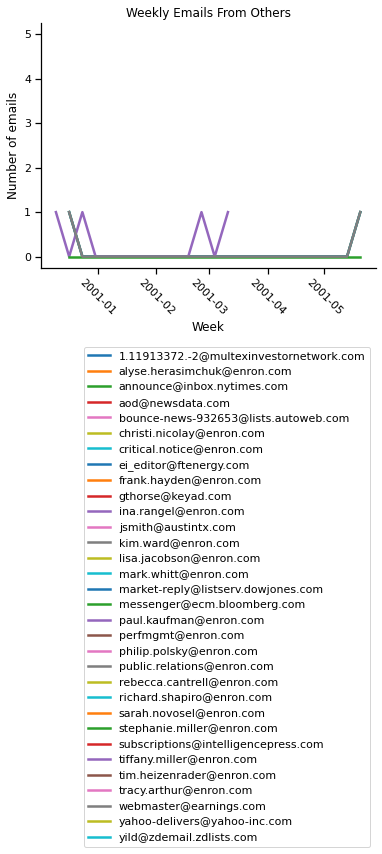

In [23]:
grouped_by_sender = df_clean.set_index('new_date').groupby(['From'])
fig = plt.figure(figsize=(6, 4.5))

for group in grouped_by_sender.groups:
    if group == 'phillip.allen@enron.com': continue
    df = grouped_by_sender.get_group(group)
    sns.lineplot(
    data=df.loc['2000-11-01':,'To'].resample("1w").count(), 
    label = group,
    linewidth=2.5)
plt.title('Weekly Emails From Others')
plt.ylabel('Number of emails')
plt.xlabel('Week')
plt.xticks(rotation = -45)
plt.legend(bbox_to_anchor=(1, -0.3))
sns.despine()
    

# Topic Extraction


## TF-IDF

In [24]:
n_features = 1000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=n_features,
                            stop_words='english',
                            ngram_range=(1,3),
                            token_pattern=u'(?ui)\\b\\w*[a-z]{3,}\\w*\\b') # Ignore Case, Words with 3+ chars, no numbers 
tfidf = tfidf_vectorizer.fit_transform(df_clean.content)
print(tfidf_vectorizer.get_feature_names())

['ability', 'able', 'accepted', 'access', 'according', 'account', 'actual', 'add', 'additional', 'address', 'address book', 'afternoon', 'agreement', 'ahead', 'alan', 'alan comnes', 'alan comnes pdx', 'allan', 'allan severude', 'allen', 'allen enron', 'allen enron com', 'allen hou', 'allen hou ect', 'allen pallen', 'allen pallen enron', 'america', 'america corp', 'analysis', 'analyst', 'analysts', 'answer', 'aol', 'application', 'appraisal', 'approval', 'approved', 'approximately', 'april', 'area', 'arnold', 'asked', 'asp', 'attached', 'attorney', 'attractive', 'august', 'austin', 'austin com', 'austin com phillip', 'austin com respond', 'available', 'average', 'badeer', 'badeer hou', 'badeer hou ect', 'balance', 'bank', 'barry', 'based', 'basis', 'beginning', 'belden', 'belden hou', 'belden hou ect', 'believe', 'best', 'better', 'bid', 'billion', 'bills', 'black', 'bloomberg', 'bloomberg energy', 'bob', 'bond', 'book', 'bpa', 'brenda', 'brian', 'bridge', 'bridge loan', 'bring', 'brown

ngram_range yields some unwanted ngrams like "phillip forwarded phillip". Let's check only 1-grams.
Scikit-learn doesn't lemmatize words. Let's fix that with SpaCy: 

We got both rental and rent. Let's try spacy:

In [25]:
# Check a sample email
nlp = spacy.load('en_core_web_sm')
doc = nlp(df_clean.content[10])
for token in doc:
    print(token.lemma_, token.pos_)

Mr. PROPN
Buckner PROPN
, PUNCT


  SPACE
for ADP
deliver VERB
gas NOUN
behind ADP
San PROPN
Diego PROPN
, PUNCT
Enron PROPN
Energy PROPN
Services PROPN
be AUX
the DET
appropriate ADJ

 SPACE
Enron PROPN
entity NOUN
. PUNCT
  SPACE
-PRON- PRON
have AUX
forward VERB
-PRON- DET
request NOUN
to ADP
Zarin PROPN
Imam PROPN
at ADP
EES PROPN
. PUNCT
  SPACE
-PRON- DET
phone NOUN

 SPACE
number NOUN
be AUX
713 NUM
- PUNCT
853 NUM
- PUNCT
7107 NUM
. PUNCT
 

 SPACE
Phillip PROPN
Allen PROPN


Let's keep adjectives, nouns, and verbs only.

In [26]:
class SpacyTokenizer:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm')
        
    def __call__(self, doc):
        doc = self.nlp(doc)
        result = [token.lemma_ for token in doc\
                  if token.pos_ in ["ADJ", "NOUN", "VERB"] and\
                  re.fullmatch(u'(?ui)\\b\\w*[a-z]{3,}\\w*\\b', # Ignore Case, Words with 3+ chars, no numbers
                               token.lemma_)]       
        return result


In [27]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                            max_features=n_features,
                            stop_words='english',
                            tokenizer=SpacyTokenizer())
tfidf = tfidf_vectorizer.fit_transform(df_clean.content)
print(tfidf_vectorizer.get_feature_names())

['ability', 'able', 'accept', 'acceptable', 'access', 'accord', 'account', 'accurate', 'action', 'active', 'activity', 'actual', 'add', 'addition', 'additional', 'address', 'adjust', 'adjustment', 'advance', 'afternoon', 'agenda', 'agree', 'agreement', 'ahead', 'air', 'alert', 'allow', 'alternative', 'analysis', 'analyst', 'annual', 'answer', 'apartment', 'appear', 'application', 'apply', 'appraisal', 'appraise', 'appreciate', 'appropriate', 'approval', 'approve', 'architect', 'area', 'article', 'ask', 'assert', 'assessment', 'asset', 'assistance', 'assistant', 'associate', 'assume', 'assumption', 'attach', 'attachment', 'attempt', 'attend', 'attention', 'attorney', 'attractive', 'audio', 'audit', 'authority', 'authorize', 'available', 'average', 'avoid', 'bad', 'balance', 'bank', 'bankruptcy', 'base', 'baseload', 'basic', 'basis', 'bath', 'bedroom', 'begin', 'beginning', 'belief', 'believe', 'benefit', 'bid', 'bidweek', 'big', 'bike', 'bishop', 'blackout', 'bloomberg', 'bond', 'book',

# Topics
## Topics using NMF
Let's get topics from email bodies using matrix decomposition:

In [30]:
n_top_words = 10
n_topics = 20
nmf = NMF(n_components=n_topics, random_state=random_state,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

topics = {}
col_names = ['top_words', 'topic']
for topic_idx, topic in enumerate(nmf.components_):
        top_words = " ".join([tfidf_feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics[topic_idx]=[top_words, '']

df_nmf_topics = pd.DataFrame.from_dict(topics,  orient='index', columns = col_names)

In [31]:
pd.options.display.max_colwidth = 100
print("\nTopics in NMF model (Frobenius norm):")
print(df_nmf_topics['top_words'])


Topics in NMF model (Frobenius norm):
0         project cost construction builder estimate time unit contract bid sell
1          forward subject attach gas strategy generation dyer map western chart
2              thank access help password address send trader user grant problem
3                  rent email pay week rentroll miss question deposit tenant new
4          trading resume interview send track analyst program group round think
5           meeting tomorrow discuss morning cap discussion date start time hold
6                gas price demand market forecast load index point daily storage
7                  check new click mail site notice web follow instruction image
8       today office information form calendar migration time book email address
9                              let work like know talk need try quote model home
10    file attach open format response different confirm send attachment operate
11                  cost loan unit note location cash add total distri

In [32]:
# Assign topic to each review:
doc_topic = nmf.transform(tfidf)
topics = np.array([])
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topics = np.append(topics, [topic_most_pr], axis=0)
df_clean['topic_nmf'] = topics.astype(int)
df_clean

,From,To,Subject,content,new_date,type,topic_nmf
716,phillip.allen@enron.com,"john.lavorato@enron.com,scott.neal@enron.com,thomas.martin@enron.com,hunter.shively@enron.com,jo...",systems wish list,attached is the systems wish list for the gas basis and physical trading\n,1980-01-01 00:00:00,internal,1
715,phillip.allen@enron.com,jsmith@austintx.com,Re: MISSION SOUTH,"Jeff,\n\n I want to bid $2.8 for sagewood with a rate 8.5% or less and dependent on \n30 year term",1980-01-01 00:00:00,external,18
698,phillip.allen@enron.com,"stephen.harrington@enron.com,mary@enron.com",NaN,EOL report for TV in conference on 33\n\n\nCash\n \n-Hehub\n-Chicago\n-PEPL\n-Katy\n -W...,1980-01-01 00:00:00,internal,16
664,phillip.allen@enron.com,muller@thedoghousemail.com,Re: (No Subject),How is your racing going? What category are you up to? \n\nI,1980-01-01 00:00:00,external,0
842,phillip.allen@enron.com,maryrichards7@hotmail.com,Re:,"Mary,\n\n It is OK to buy a carpet shampooer.\n About the W-2's, how would you",1980-01-01 00:00:00,external,13
...,...,...,...,...,...,...,...
881,ei_editor@ftenergy.com,einsighthtml@spector.ftenergy.com,Texas puts reliability rules through paces,Dear Energy Insight Subscribers.?If you cannot read?this version of the=\n=20\nEnergy Insight ...,2001-05-14 16:39:00,external,7
883,webmaster@earnings.com,pallen@enron.com,"Freidman, Billings Initiates Coverage of PMCS","If you cannot read this email, please click here. \n\nEarnings.com - PMCS Upgrade/Downgrade Hist...",2001-05-14 17:24:00,external,13
882,perfmgmt@enron.com,pallen@enron.com,Mid-Year 2001 Performance Feedback,"ALLEN, PHILLIP K,\n?\nYou have been selected to participate in the Mid Year 2001 Performance \nM...",2001-05-14 17:32:00,internal,16
116,phillip.allen@enron.com,outlook.team@enron.com,Re: 2- SURVEY/INFORMATION EMAIL 5-14- 01,\n\n\n\n\nOutlook Migration Team@ENRON\n05/11/2001 01:49 PM\nTo:=09Cheryl Wilchynski/HR/Corp/Enr...,2001-05-14 20:39:00,internal,8


Let's manually assign titles based on top words in each topic:

Topic 0 sample emails:

In [78]:
topic_no = 0
print(df_nmf_topics.iloc[topic_no],'\n--------\n')
i = 15
for ind, row in df_clean.loc[df_clean['topic_nmf']==topic_no].iterrows():
    i-=1
    if i==0: break
    print(row['content'], '\n==============================================\n')

top_words    project cost construction builder estimate time unit contract bid sell
topic                                                      Cost and return estimate
Name: 0, dtype: object 
--------

How is your racing going?  What category are you up to? 

I 

Call me. I can't get out. 

Julie,

 The numbers for January are below:

  Actual flows X gas daily spreads          $ 463,000
  Actual flow X Index spreads           $ 543,000
  Jan. value from original bid           $1,750,000
  Estimated cost to unwind hedges         ($1,000,000) 

 Based on these numbers, I suggest we offer to pay at least $500,000 but no 
more than $1,500,000.  I want your input on
 how to negotiate with El Paso.  Do we push actual value, seasonal shape, or 
unwind costs?  

Phillip 
  

2000-1969=31 

Laird,

 Did you meet with SWG on April 27th.  Are there any other asset management 
targets in the west?


---------------------- Forwarded by Phillip K Allen/HOU/ECT on 04/27/2000 
01:53 PM --------------

Let's assign 'Cost and return estimate' to topic 0:

In [34]:
df_nmf_topics.iloc[0,1] = 'Cost and return estimate'

To save some space in the notebook, I will not print the email bodies for other topics.

In [35]:
df_nmf_topics.iloc[1,1] = 'Strategy briefing'
df_nmf_topics.iloc[2,1] = 'Grant access'
df_nmf_topics.iloc[3,1] = 'Property rent related'
df_nmf_topics.iloc[4,1] = 'Staffing and on-boarding'
df_nmf_topics.iloc[5,1] = 'Meeting scheduling'
df_nmf_topics.iloc[6,1] = 'Gas price estimate'
df_nmf_topics.iloc[7,1] = 'Advertisement'
df_nmf_topics.iloc[8,1] = 'Email service migration'
df_nmf_topics.iloc[9,1] = 'In-home services'
df_nmf_topics.iloc[10,1] = 'Email with attachement'
df_nmf_topics.iloc[11,1] = 'Property sale'
df_nmf_topics.iloc[12,1] = 'Update reminder'
df_nmf_topics.iloc[13,1] = 'Furniture'
df_nmf_topics.iloc[14,1] = 'Spreadsheet'
df_nmf_topics.iloc[15,1] = 'IT related'
df_nmf_topics.iloc[16,1] = 'Stock trading'
df_nmf_topics.iloc[17,1] = 'Staff promotion'
df_nmf_topics.iloc[18,1] = 'Financing and trading'
df_nmf_topics.iloc[19,1] = 'Car repair'

After assigning titles to each NMF topic, I realized that some top words from NMF did not represent the document bodies that well. For example, I could title Topic 19 as car repair, fine payment, or checking on a sick person! It seems like NMF does not return the best describing terms for emails. 

Let's visualize the distribution of emails from Phillip Allen and their topics:

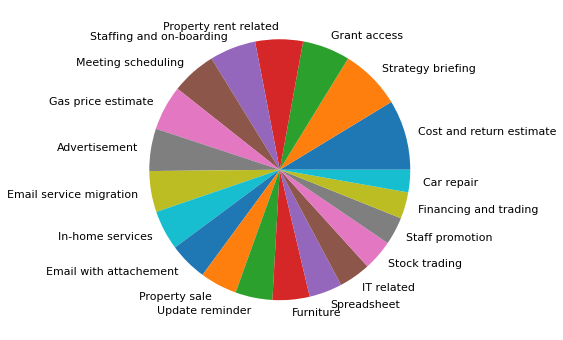

In [47]:
grouped_by_sender = df_clean.groupby(['From'])
i=0
person = grouped_by_sender.get_group('phillip.allen@enron.com')
data = person['topic_nmf'].value_counts()
fig = plt.figure(figsize=(6,6))
plt.pie(data, labels = df_nmf_topics['topic'].to_numpy())
plt.show()

## Topics using bag of words

Let's get topics as common n-grams:

In [48]:
def top_ngrams(corpus, return_count=None, n=2, tokenizer = SpacyTokenizer()):
    vec = CountVectorizer(ngram_range=(n, n),
                          tokenizer=tokenizer,
                          min_df = 3, max_df = 0.9).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:return_count]

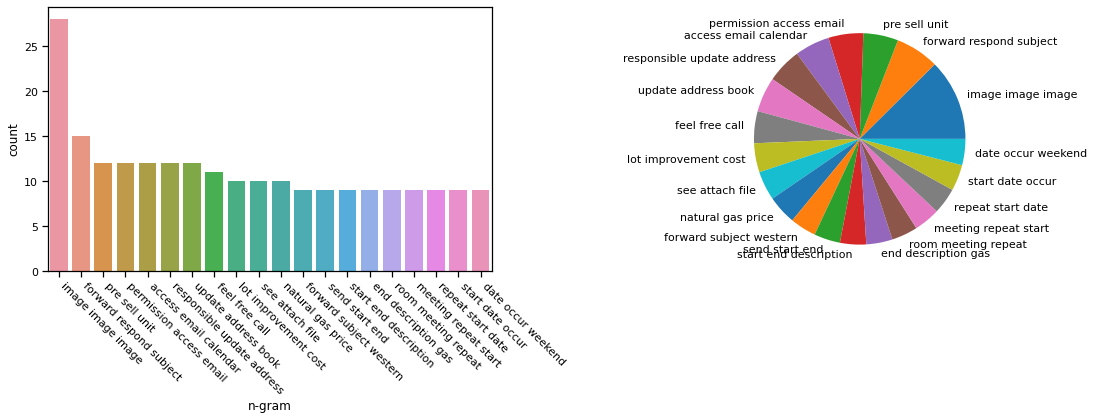

In [61]:
grams = top_ngrams(df_clean['content'], 20, n=3)
df_ngrams = pd.DataFrame(grams, columns = ['n-gram' , 'count'])
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
ax1 = sns.barplot(x='n-gram', y='count', data=df_ngrams, ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=-45, ha='left')
ax2.pie(df_ngrams['count'].to_numpy(), labels = df_ngrams['n-gram'].to_numpy())
plt.tight_layout()
plt.show()

Let's add proper nouns to Spacy Tokenizer and check common n-grams as topics:

In [39]:
class ProperNounTokenizer(SpacyTokenizer): #Spacy Tokenizer incuding proper nouns
    def __init__(self):
        super().__init__()
        
    def __call__(self, doc):
        doc = self.nlp(doc)
        result = [token.lemma_ for token in doc\
                  if token.pos_ in ["ADJ", "NOUN", "VERB", "PROPN"] and\
                  re.fullmatch(u'(?ui)\\b\\w*[a-z]{3,}\\w*\\b', # Ignore Case, Words with 3+ chars, no numbers
                   token.lemma_)]       
        return result

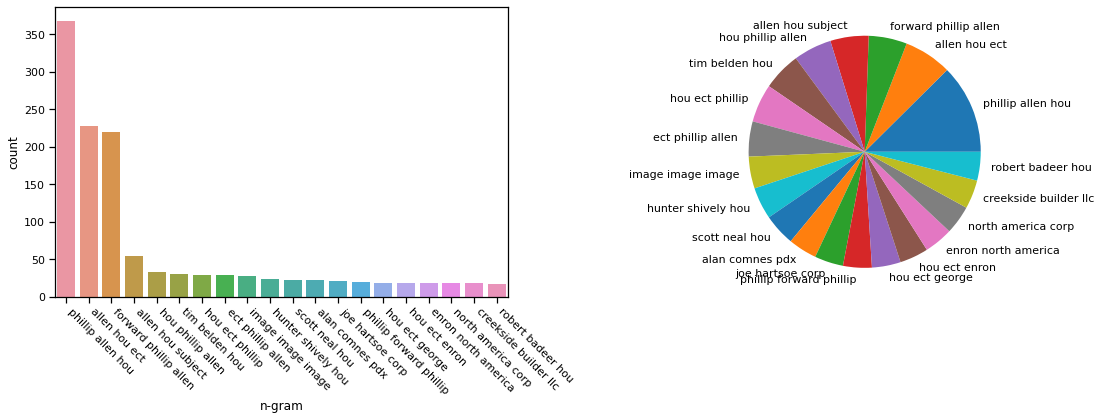

In [63]:
grams = top_ngrams(df_clean['content'], 20, n=3, tokenizer = ProperNounTokenizer())
df_ngrams_p = pd.DataFrame(grams, columns = ['n-gram' , 'count'])
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
ax1 = sns.barplot(x='n-gram', y='count', data=df_ngrams_p, ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=-45, ha='left')
ax2.pie(df_ngrams['count'].to_numpy(), labels = df_ngrams_p['n-gram'].to_numpy())
plt.tight_layout()
plt.show()

We have a lot of "Phillip Allen" in trigrams. Let's change to bigrams to group them:

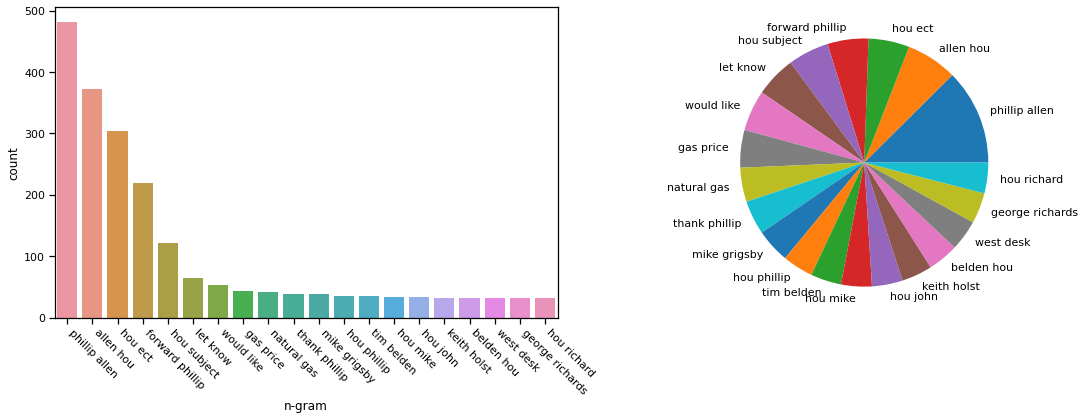

In [62]:
grams = top_ngrams(df_clean['content'], 20, n=2, tokenizer = ProperNounTokenizer())
df_ngrams_p = pd.DataFrame(grams, columns = ['n-gram' , 'count'])
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
ax1 = sns.barplot(x='n-gram', y='count', data=df_ngrams_p, ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=-45, ha='left')
ax2.pie(df_ngrams['count'].to_numpy(), labels = df_ngrams_p['n-gram'].to_numpy())
plt.tight_layout()
plt.show()

# Topics using LDA
Let's get topics from email bodies using LDA:

In [71]:
n_top_words = 10
n_topics = 20

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english',
                                tokenizer=SpacyTokenizer())
tf = tf_vectorizer.fit_transform(df_clean['content'])
# tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=random_state,
                                n_jobs=-1)

lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names()


In [83]:
topics = {}
col_names = ['top_words', 'topic']
for topic_idx, topic in enumerate(lda.components_):
    top_words = " ".join([tfidf_feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
    topics[topic_idx]=[top_words, '']
        
df_lda_topics = pd.DataFrame.from_dict(topics,  orient='index', columns = col_names)
df_lda_topics

,top_words,topic
0,loan cost construction cash fee contract land bond total fund,
1,price power say trader trade mail high day hour gas,
2,basis quote release status draw desk approve lime specialist manager,
3,state power forward bond issue subject source report socal update,
4,loan copy thank investment provide month column application expense information,
5,image forward gas subject report account transfer bad reach offer,
6,print hear page mile messenger great hunter bike glad road,
7,completion answer predict place weekend picture revenue communication single comment,
8,shockmachine tax download mail return statement sufficient asset home want,
9,lime roman cement book building concrete clay research structure use,


Let's visualize these topics and the common words between them:

In [84]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.146801 -0.136973       1        1  12.936061
1     -0.023147  0.197492       2        1  25.798135
2     -0.001948  0.009247       3        1   1.081060
3      0.056747  0.115859       4        1  15.416873
4      0.050912 -0.046496       5        1   1.475121
5     -0.006528 -0.004838       6        1   0.116875
6     -0.003054 -0.004187       7        1   0.328856
7     -0.004219 -0.006993       8        1   0.116875
8     -0.002950 -0.005245       9        1   0.195382
9     -0.000202 -0.013410      10        1   0.279724
10    -0.004279 -0.009575      11        1   0.122310
11    -0.003549 -0.008222      12        1   0.116875
12    -0.290961 -0.065285      13        1   2.163262
13     0.019772 -0.003332      14        1   1.033822
14    -0.000604 -0.011892      15        1   0.118913
15    -0.002488 -0.007528      16        1   0.116875
16     0.025051 -0.051241      17        1   2.701703
17    -0.005450 -0.006410      18        1   0.154980
18    -0.003692  0.009643      19        1   0.482575
19     0.053788  0.049387      20        1  35.243723, topic_info=        Term        Freq       Total Category  logprob  loglift
504     loan  205.000000  205.000000  Default  30.0000  30.0000
110      buy   81.000000   81.000000  Default  29.0000  29.0000
196     cost  176.000000  176.000000  Default  28.0000  28.0000
369  forward  200.000000  200.000000  Default  27.0000  27.0000
380      gas  157.000000  157.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
290    email   68.841395  127.906048  Topic20  -4.8331   0.4234
582   number   45.967704   70.631493  Topic20  -5.2370   0.6133
952      use   65.860461  147.868350  Topic20  -4.8774   0.2341
912    thank   50.940248  102.901614  Topic20  -5.1343   0.3398
380      gas   49.322034  157.243281  Topic20  -5.1666  -0.1165

[1156 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.351657   able
1         2  0.316491   able
1         4  0.035166   able
1        17  0.035166   able
1        20  0.246160   able
...     ...       ...    ...
996      20  0.822436  write
997       1  0.042496   year
997       2  0.169983   year
997       4  0.106239   year
997      20  0.658682   year

[2084 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

**Topic numbers start from 1 in this visualization. Topic 0 shows the term frequency in the entire corpus.**

This interactive graph shows that non-overlapping topics are Topic 1, 2, 5, 13, and 17. Topic 4 is mostly covered by Topic 20.  The bar chart in the right panel shows the 30 most relevent terms for each selected topic. Given a weight parameter λ, we can calculate the relevence of a term to a topic using:  λ log(p(term | topic)) + (1 - λ) log(p(term | topic)/p(term)). The red bars represent the frequency of a term in the selected topic proportional to p(term|topic). The blue bars represent frequency of a term in all documents proportional to p(term). By changing λ, we can adjust the term rankings. Smaller λs prioritize  rare and exclusive terms in a topic. Large λs prioritize frequent terms that are not necessarily exclusive for each topic. 

In [79]:
# Assign topic to each review:
doc_topic = lda.transform(tf)
topics = np.array([])
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topics = np.append(topics, [topic_most_pr], axis=0)
df_clean['topic_lda'] = topics.astype(int)

In [85]:
topic_no = 1
print(df_lda_topics.iloc[topic_no],'\n--------\n')
i = 15
for ind, row in df_clean.loc[df_clean['topic_lda']==topic_no].iterrows():
    i-=1
    if i==0: break
    print(row['content'], '\n==============================================\n')

top_words    price power say trader trade mail high day hour gas
topic                                                           
Name: 1, dtype: object 
--------

attached is the systems wish list for the gas basis and physical trading
 

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 12/11/99 02:39 
PM ---------------------------


"the shockwave.com team" <shockwave.com@shockwave.m0.net> on 11/05/99 
02:49:43 AM
Please respond to shockwave.com@shockwave.m0.net
To: Phillip K Allen/HOU/ECT@ECT
cc:  
Subject: Stick it in your Shockmachine!



First one's free. So are the next thousand.

You know it's true: Video games are addictive. Sure, we could
trap you with a free game of Centipede, then kick up the price
after you're hooked. But that's not how shockwave.com operates.
Shockmachine -- the greatest thing since needle exchange -- is
now free; so are the classic arcade games. Who needs quarters?
Get Arcade Classics from shockwave.com, stick 'em in your
Shockmachine and 

In [ ]:
df_lda_topics.iloc[0,1] = 'Financial planning' # By changing λ from 1 to 0, loan and cost stay the most representative terms
df_lda_topics.iloc[1,1] = 'Product management' # By changing λ from 1 to 0.8, price and power stay the most representative terms
df_lda_topics.iloc[2,1] = ''
df_lda_topics.iloc[3,1] = ''
df_lda_topics.iloc[4,1] = ''
df_lda_topics.iloc[5,1] = ''
df_lda_topics.iloc[6,1] = ''
df_lda_topics.iloc[7,1] = ''
df_lda_topics.iloc[8,1] = ''
df_lda_topics.iloc[9,1] = ''
df_lda_topics.iloc[10,1] = ''
df_lda_topics.iloc[11,1] = ''
df_lda_topics.iloc[12,1] = ''
df_lda_topics.iloc[13,1] = ''
df_nmf_topics.iloc[14,1] = ''
df_lda_topics.iloc[15,1] = ''
df_lda_topics.iloc[16,1] = ''
df_lda_topics.iloc[17,1] = ''
df_lda_topics.iloc[18,1] = ''
df_lda_topics.iloc[19,1] = ''